<a href="https://colab.research.google.com/github/noamshimsho/NLP/blob/main/Chapter_7_Question_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In This Notebook:

*   extractive QA (ds - subjqa)
*   EDA
*   Tokenizing text for QA

In [1]:
!pip install -q transformers[sentencepiece] datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 11.4 MB/s eta 0:00:00


# THE DATA

In [2]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [3]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

Dataset subjqa downloaded and prepared to /root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
subjqa

DatasetDict({
    train: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 1295
    })
    test: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 358
    })
    validation: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 255
    })
})

In [5]:
subjqa['train'].column_names

['domain',
 'nn_mod',
 'nn_asp',
 'query_mod',
 'query_asp',
 'q_reviews_id',
 'question_subj_level',
 'ques_subj_score',
 'is_ques_subjective',
 'review_id',
 'id',
 'title',
 'context',
 'question',
 'answers']

In [6]:
print(subjqa["train"]["question"][1])

Is this music song have a goo bass?


In [7]:
print(subjqa["train"]["context"][1])

To anyone who hasn't tried all the various types of headphones, it is important to remember exactly what these are: cheap portable on-ear headphones. They give a totally different sound then in-ears or closed design phones, but for what they are I would say they're good. I currently own six pairs of phones, from stock apple earbuds to Sennheiser HD 518s. Gave my Portapros a run on both my computer's sound card and mp3 player, using 256 kbps mp3s or better. The clarity is good and they're very lightweight. The folding design is simple but effective. The look is certainly retro and unique, although I didn't find it as comfortable as many have claimed. Earpads are *very* thin and made my ears sore after 30 minutes of listening, although this can be remedied to a point by adjusting the "comfort zone" feature (tightening the temple pads while loosening the ear pads). The cord seems to be an average thickness, but I wouldn't get too rough with these. The steel headband adjusts smoothly and e

In [8]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [9]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [10]:
dfs['train'].head(3)

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective
0,electronics,great,bass response,excellent,bass,0514ee34b672623dff659334a25b599b,5,0.5,False,882b1e2745a4779c8f17b3d4406b91c7,2543d296da9766d8d17d040ecc781699,B00001P4ZH,"I have had Koss headphones in the past, Pro 4A...",How is the bass?,[],[],[],[],[]
1,electronics,harsh,high,not strong,bass,7c46670208f7bf5497480fbdbb44561a,1,0.5,False,ce76793f036494eabe07b33a9a67288a,d476830bf9282e2b9033e2bb44bbb995,B00001P4ZH,To anyone who hasn't tried all the various typ...,Is this music song have a goo bass?,"[Bass is weak as expected, Bass is weak as exp...","[1302, 1302]","[1, 1]","[0.5083333, 0.5083333]","[True, True]"
2,electronics,neutral,sound,present,bass,8fbf26792c438aa83178c2d507af5d77,1,0.5,False,d040f2713caa2aff0ce95affb40e12c2,455575557886d6dfeea5aa19577e5de4,B00001P4ZH,I have had many sub-$100 headphones from $5 Pa...,How is the bass?,[The only fault in the sound is the bass],[650],[2],[0.6333333],[True]



**title** - The Amazon Standard Identification Number (ASIN) associated with each product

**question** - The question

**answers.answer_text** - The span of text in the review labeled by the annotator

**answers.answer_start** - The start character index of the answer span

**context** - The customer review

In [11]:
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


From these examples we can make a few observations. 

First, the questions are not grammatically correct, which is quite common in the FAQ sections of ecommerce websites. 

Second, an empty answers.text entry denotes “unanswerable” questions whose answer cannot be found in the review.

In [12]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
start_idx, end_idx, sample_df["context"].iloc[0][start_idx:end_idx]

(215, 239, 'this keyboard is compact')

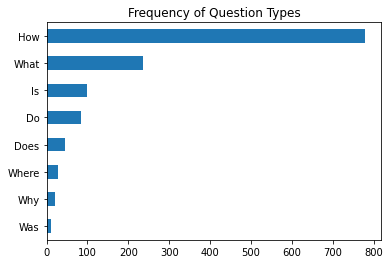

In [13]:
import matplotlib.pyplot as plt
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [14]:
dfs["train"]["question"].str.startswith(q).value_counts()

False    1274
True       21
Name: question, dtype: int64

In [15]:
counts

{'What': 236,
 'How': 780,
 'Is': 100,
 'Does': 45,
 'Do': 83,
 'Was': 12,
 'Where': 28,
 'Why': 21}

In [16]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


# Extracting Answers from Text



*   Frame the supervised learning problem.
*   Tokenize and encode text for QA tasks.
*   Deal with long passages that exceed a model’s maximum context size.







**Span classification**

The most common way to extract answers from text is by framing the problem as a span classification task, where the start and end tokens of an answer span act as the labels that a model needs to predict

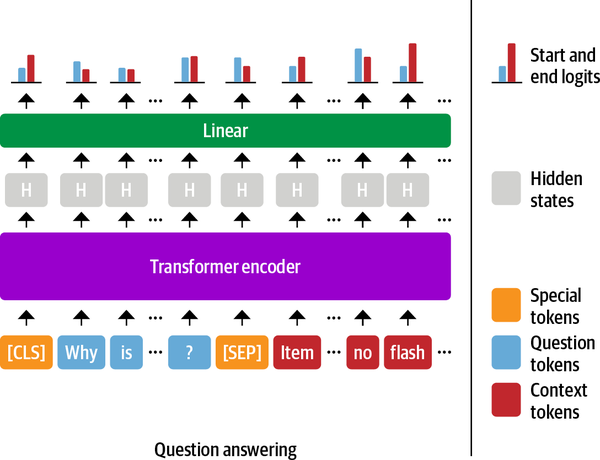

Since our training set is relatively small, with only 1,295 examples, a good strategy is to start with a language model that has already been fine-tuned on a large-scale QA dataset like SQuAD.

**For extractive QA, we can actually start with a fine-tuned model since the structure of the labels remains the same across datasets.**

*https://huggingface.co/models?pipeline_tag=question-answering&search=squad*

Transformer,	Description,	Number of parameters,	F1-score on SQuAD 2.0

**MiniLM**

A distilled version of BERT-base that preserves 99% of the performance while being twice as fast - 66M -79.5

**RoBERTa-base**

RoBERTa models have better performance than their BERT counterparts and can be fine-tuned on most QA datasets using a single GPU 125M 83.0

**ALBERT-XXL**

State-of-the-art performance on SQuAD 2.0, but computationally intensive and difficult to deploy - 235M - 88.1

**XLM-RoBERTa-large**

Multilingual model for 100 languages with strong zero-shot performance - 570M - 83.8



For the purposes of this chapter, we’ll use a fine-tuned MiniLM model since it is fast to train

## Tokenizing text for QA

In [17]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [18]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [19]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [20]:
pd.DataFrame([inputs['input_ids'][0].numpy() ,inputs['token_type_ids'][0].numpy()], index=['input_ids', 'token_type_ids'])

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1


In [21]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [22]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [23]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [24]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")  # the output cover also the question part...

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


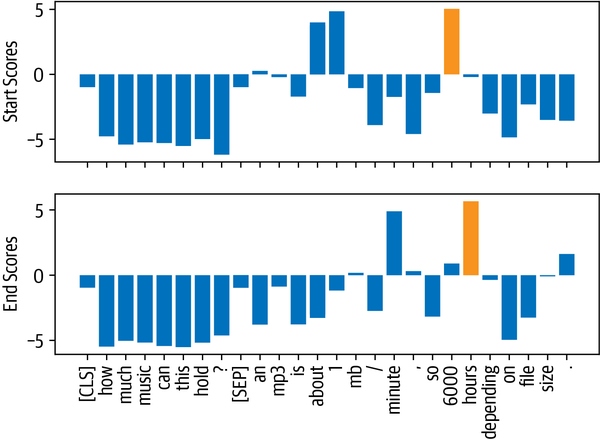

In [25]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [26]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/question_answering.py:325: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651616334915161, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082962095737457,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253521054983139,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [27]:
# no answer is possible,
pipe(question="Why is there no data?", context=context, handle_impossible_answer=True, topk=2)

[{'score': 0.9068413972854614, 'start': 0, 'end': 0, 'answer': ''},
 {'score': 0.00026264850748702884,
  'start': 16,
  'end': 71,
  'answer': '1 MB/minute, so about 6000 hours depending on file size'}]

## Dealing with long passages

For other tasks, like text classification, we simply truncated long texts under the assumption that enough information was contained in the embedding of the [CLS] token to generate accurate predictions. 

For QA, however, this strategy is problematic because the answer to a question could lie near the end of the context and thus would be removed by truncation.

**sliding window**

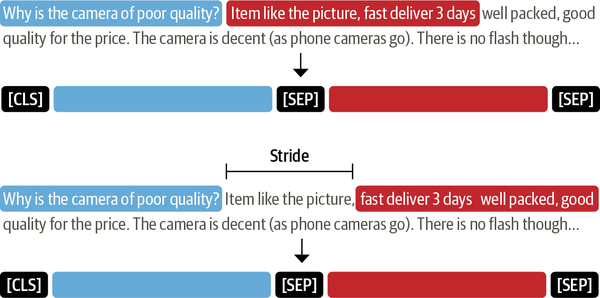

In [28]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, 
                              max_length=100,
                              stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [29]:
tokenized_example

{'input_ids': [[101, 2129, 2003, 1996, 3321, 1029, 102, 1045, 2031, 2018, 12849, 4757, 2132, 19093, 1999, 1996, 2627, 1010, 4013, 26424, 2050, 1998, 1053, 2480, 1011, 5585, 1012, 1996, 12849, 4757, 3417, 9331, 3217, 2003, 12109, 1998, 2038, 2307, 3321, 3433, 1012, 1996, 2147, 2307, 2007, 2026, 11924, 3042, 1998, 2064, 2022, 1000, 4565, 2039, 1000, 2000, 2022, 3344, 1999, 2026, 9055, 6598, 2030, 3274, 4524, 2302, 2893, 24514, 2098, 1012, 2027, 2024, 2200, 2422, 1998, 2079, 2025, 2514, 3082, 2030, 4562, 2091, 2006, 2115, 5551, 2130, 2044, 5962, 2000, 2189, 2007, 2068, 2006, 2035, 2154, 1012, 1996, 2614, 2003, 102], [101, 2129, 2003, 1996, 3321, 1029, 102, 1998, 2079, 2025, 2514, 3082, 2030, 4562, 2091, 2006, 2115, 5551, 2130, 2044, 5962, 2000, 2189, 2007, 2068, 2006, 2035, 2154, 1012, 1996, 2614, 2003, 2305, 1998, 2154, 2488, 2084, 2151, 4540, 1011, 13007, 2071, 2022, 1998, 2024, 2471, 2004, 2204, 2004, 1996, 4013, 26424, 2050, 1012, 2027, 2024, 1000, 2330, 2250, 1000, 2132, 19093, 2061,

In [30]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [31]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



# Using Haystack to Build a QA Pipeline

in reality our system’s users will only provide a question about a product, so we need some way of selecting relevant passages from among all the reviews in our corpus

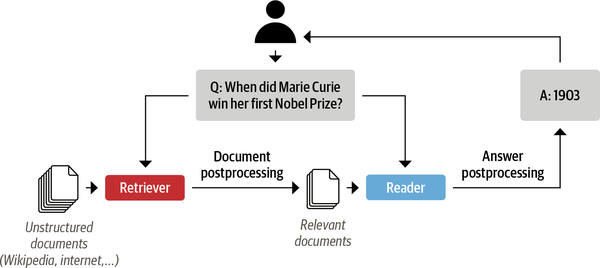

**Retriever**

Responsible for retrieving relevant documents for a given query. Retrievers are usually categorized as sparse or dense. Sparse retrievers use word frequencies to represent each document and query as a sparse vector.11 The relevance of a query and a document is then determined by computing an inner product of the vectors. On the other hand, dense retrievers use encoders like transformers to represent the query and document as contextualized embeddings (which are dense vectors). These embeddings encode semantic meaning, and allow dense retrievers to improve search accuracy by understanding the content of the query.

To build our QA system, we’ll use the Haystack library developed by deepset

In addition to the retriever and reader, there are two more components involved when building a QA pipeline with Haystack:

**Document store**

A document-oriented database that stores documents and metadata which are provided to the retriever at query time

**Pipeline**

Combines all the components of a QA system to enable custom query flows, merging documents from multiple retrievers, and more

**Initializing a document store:**

         In memory,	Elastic_search,	FAISS,	Milvus

**TF-IDF-** Yes Yes No No

**BM25-** No Yes No No

**Embedding-** Yes Yes Yes Yes

**DPR-** Yes Yes Yes Yes
